<a href="https://colab.research.google.com/github/dk-wei/customer-driven-ds/blob/main/Growth_Hacker_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install ipython-autotime
%load_ext autotime

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
import datetime as dt
import seaborn as sns

# warnings.filterwarnings("ignore")

from tensorflow import keras
%load_ext tensorboard

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0
time: 3.06 s (started: 2021-07-28 18:06:04 +00:00)


数据来源：`https://www.kaggle.com/vijayuv/onlineretail`

In [18]:
# df_purchase = pd.read_csv('purchase data.csv')

from google.colab import drive
drive.mount('/content/drive')

# Load the data, contained in the segmentation data csv file.
GD_PATH = '/content/drive/MyDrive/扬FAANG起航/单项准备/customer analytics/'
tx_data = pd.read_csv(GD_PATH+'OnlineRetail.csv', encoding = 'latin1', index_col = 0).reset_index()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 821 ms (started: 2021-07-28 18:06:07 +00:00)


# Part 1: [Know Your Metrics](https://towardsdatascience.com/data-driven-growth-with-python-part-1-know-your-metrics-812781e66a5b) (Cohort and Retention Analysis)


我们采用的是`North Star metrics` + `Satellite metrics`的方式，也就是最重要的Core业务指标，搭配上一些防御性指标(retention rate, churn rate, new customer ratio)


> *The North Star Metric is the single metric that best captures the core value that your product delivers to customers.  -- Sean Ellis*

做产品可能什么都想要，要更多顾客，要更多orders，要更多revenue，要更多signups，更有效率，但是请注意，太多的focus就是木有focus。在不同的阶段，公司可能也有不同的focus。

从公司层面，一般都是一个很大的，最核心的metrics：

  1. Airbnb’s North Star Metric is nights booked (NB). 
  2. for Facebook, it is daily active users (DAU).

本例为online retail，我们最关注的是`Monthly Revenue` . 每月利润

> Revenue = Active Customer Count * Order Count * Average Revenue per Order


In [19]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


time: 30.6 ms (started: 2021-07-28 18:06:08 +00:00)


In [20]:
#converting the type of Invoice Date Field from string to datetime.
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

#creating YearMonth field for the ease of reporting and visualization
tx_data['InvoiceYearMonth'] = tx_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
tx_data['Revenue'] = tx_data['UnitPrice'] * tx_data['Quantity']

tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


time: 4.98 s (started: 2021-07-28 18:06:08 +00:00)


each row: invoiceNo, datetime, revenue, customerId

## Core Metrics

### Monthly Revenue

now we have a dataframe that shows our monthly revenue

In [21]:
tx_revenue = tx_data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_revenue.head()

,InvoiceYearMonth,Revenue
0,201012,748957.020
1,201101,560000.260
2,201102,498062.650
3,201103,683267.080
4,201104,493207.121


time: 23.8 ms (started: 2021-07-28 18:06:13 +00:00)


In [22]:
#X and Y axis inputs for Plotly graph. We use Scatter for line graphs

import plotly.graph_objects as go

plot_data = [
    go.Scatter(
        x=tx_revenue['InvoiceYearMonth'],
        y=tx_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show()

time: 176 ms (started: 2021-07-28 18:06:13 +00:00)



### Monthly Revenue Growth Rate

This clearly shows our revenue is growing especially Aug ‘11 onwards (and our data in December is incomplete). Absolute numbers are fine, let’s figure out what is our **Monthly Revenue Growth Rate**:

> Monthly Revenue Growth Rate = revenue of this month / revenue of last month

In [23]:
#using pct_change() function to see monthly percentage change
tx_revenue['MonthlyGrowth'] = tx_revenue['Revenue'].pct_change()

#showing first 5 rows
tx_revenue.head()

#visualization - line graph
plot_data = [
    go.Scatter(
        x=tx_revenue.query("InvoiceYearMonth < 201112")['InvoiceYearMonth'],
        y=tx_revenue.query("InvoiceYearMonth < 201112")['MonthlyGrowth']*100,
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate (%)'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

#pyoff.iplot(fig)

time: 194 ms (started: 2021-07-28 18:06:13 +00:00)


Everything looks good, we saw 36.5% growth previous month (December is excluded in the code since it hasn’t been completed yet). But we need to identify what exactly happened on April. Was it due to less active customers or our customers did less orders? Maybe they just started to buy cheaper products? We can’t say anything without doing a deep-dive analysis.

需要搞明白4月份到底发生了什么？


### Monthly Active (Unique) Customers

To see the details Monthly Active Customers, we will follow the steps we exactly did for Monthly Revenue. Starting from this part, we will be focusing on UK data only (**which has the most records**). We can get the monthly active customers by counting unique CustomerIDs. Code snippet and the output are as follows:

选取重点区域重点人群重点观察:
1. UK (销售额最大)
2. Active Customers (unique customers)

In [24]:
#creating a new dataframe with UK customers only
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

#creating monthly active customers dataframe by counting unique Customer IDs
tx_monthly_active = tx_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()

#print the dataframe
tx_monthly_active

#plotting the output
plot_data = [
    go.Bar(
        x=tx_monthly_active['InvoiceYearMonth'],
        y=tx_monthly_active['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)

print(tx_monthly_active)

fig.show()

    InvoiceYearMonth  CustomerID
0             201012         871
1             201101         684
2             201102         714
3             201103         923
4             201104         817
5             201105         985
6             201106         943
7             201107         899
8             201108         867
9             201109        1177
10            201110        1285
11            201111        1548
12            201112         617


time: 364 ms (started: 2021-07-28 18:06:13 +00:00)


In April, Monthly Active Customer number dropped to 817 from 923 (-11.5%).

### Monthly Order Count

We will apply the same code by using Quantity field:

In [25]:
#create a new dataframe for no. of order by using quantity field
tx_monthly_sales = tx_uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()

#print the dataframe
tx_monthly_sales

#plot
plot_data = [
    go.Bar(
        x=tx_monthly_sales['InvoiceYearMonth'],
        y=tx_monthly_sales['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Total # of Order'
    )

print(tx_monthly_sales)

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

    InvoiceYearMonth  Quantity
0             201012    298101
1             201101    237381
2             201102    225641
3             201103    279843
4             201104    257666
5             201105    306452
6             201106    258522
7             201107    324129
8             201108    319804
9             201109    458490
10            201110    455612
11            201111    642281
12            201112    199907


time: 188 ms (started: 2021-07-28 18:06:14 +00:00)


### Average Revenue per Order


In [26]:
# create a new dataframe for average revenue by taking the mean of it
tx_monthly_order_avg = tx_uk.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()

#print the dataframe
tx_monthly_order_avg

#plot the bar chart
plot_data = [
    go.Bar(
        x=tx_monthly_order_avg['InvoiceYearMonth'],
        y=tx_monthly_order_avg['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Order Average'
    )

print(tx_monthly_order_avg)

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

    InvoiceYearMonth    Revenue
0             201012  16.865860
1             201101  13.614680
2             201102  16.093027
3             201103  16.716166
4             201104  15.773380
5             201105  17.713823
6             201106  16.714748
7             201107  15.723497
8             201108  17.315899
9             201109  18.931723
10            201110  16.093582
11            201111  16.312383
12            201112  16.247406


time: 193 ms (started: 2021-07-28 18:06:14 +00:00)


Even the monthly order average dropped for April (16.7 to 15.8). We observed slow-down in every metric affecting our North Star.


### Average Revenue per Customer


In [27]:
# create a new dataframe for average revenue per customer by taking the mean of it
tx_monthly_cus_avg = tx_uk.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_monthly_cus_avg['Active Customer'] = tx_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()['CustomerID']
tx_monthly_cus_avg['Customer Avg'] = tx_monthly_cus_avg['Revenue'] / tx_monthly_cus_avg['Active Customer']
print(tx_monthly_cus_avg)

#plot the bar chart
plot_data = [
    go.Bar(
        x=tx_monthly_cus_avg['InvoiceYearMonth'],
        y=tx_monthly_cus_avg['Customer Avg'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Customer Average'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

    InvoiceYearMonth      Revenue  Active Customer  Customer Avg
0             201012   676742.620              871    776.972009
1             201101   434308.300              684    634.953655
2             201102   408247.910              714    571.775784
3             201103   559707.390              923    606.400206
4             201104   442254.041              817    541.314616
5             201105   596459.860              985    605.543005
6             201106   554478.350              943    587.994008
7             201107   565479.841              899    629.009834
8             201108   539130.500              867    621.834487
9             201109   862018.152             1177    732.385856
10            201110   877438.190             1285    682.831276
11            201111  1282805.780             1548    828.685904
12            201112   388735.430              617    630.041216


time: 244 ms (started: 2021-07-28 18:06:14 +00:00)


seems for each unique customers, they are becoming more willing to purchase our products.

## Satellite Metrics

We have looked at our major metrics. Of course there are many more and it varies across industries. Let’s continue investigating some other important metrics:

有一些metrics可能不是North Star Metrics, 但是一定是几乎每个公司都要掌握的metrics

- New Customer Ratio: a good indicator of if we are losing our existing customers or unable to attract new ones
- Retention Rate: **King of the metrics**. Indicates how many customers we retain over specific time window. We will be showing examples for monthly retention rate and cohort based retention rate.

### New Customer Ratio (min_purchase)

First we should define what is a new customer. In our dataset, we can assume a new customer is whoever did his/her first purchase in the time window we defined. 

We will do it monthly for this example.
We will be using `.min()` function to find our first purchase date for each customer and define new customers based on that. The code below will apply this function and show us the revenue breakdown for each group monthly.

> Existing customer = Customer purchase time > first purchase time

**New Customer操作方法**：找出每个customer第一次购买日期/最小购买日期，如果当时的日期大于最小日期，为`existing customer`, 否则为new customer

In [28]:
tx_uk.groupby('CustomerID')['InvoiceDate'].apply(list).reset_index(name='new').head()

,CustomerID,new
0,12346.0,"[2011-01-18 10:01:00, 2011-01-18 10:17:00]"
1,12747.0,"[2010-12-05 15:38:00, 2010-12-05 15:38:00, 201..."
2,12748.0,"[2010-12-01 12:48:00, 2010-12-02 11:46:00, 201..."
3,12749.0,"[2011-05-10 15:25:00, 2011-05-10 15:25:00, 201..."
4,12820.0,"[2011-01-17 12:34:00, 2011-01-17 12:34:00, 201..."


time: 1.19 s (started: 2021-07-28 18:06:14 +00:00)


In [29]:
#create a dataframe contaning CustomerID and first purchase date
tx_min_purchase = tx_uk.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_min_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_min_purchase['MinPurchaseYearMonth'] = tx_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)

tx_min_purchase.head()

,CustomerID,MinPurchaseDate,MinPurchaseYearMonth
0,12346.0,2011-01-18 10:01:00,201101
1,12747.0,2010-12-05 15:38:00,201012
2,12748.0,2010-12-01 12:48:00,201012
3,12749.0,2011-05-10 15:25:00,201105
4,12820.0,2011-01-17 12:34:00,201101


time: 50.3 ms (started: 2021-07-28 18:06:16 +00:00)


In [30]:
#merge first purchase date column to our main dataframe (tx_uk)
tx_uk = pd.merge(tx_uk, tx_min_purchase, on='CustomerID')

tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012


time: 221 ms (started: 2021-07-28 18:06:16 +00:00)


In [32]:
#tx_user_type_revenue.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112").head()

time: 1.06 ms (started: 2021-07-28 18:06:44 +00:00)


In [33]:
#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
tx_uk['UserType'] = 'New'
tx_uk.loc[tx_uk['InvoiceYearMonth']>tx_uk['MinPurchaseYearMonth'],'UserType'] = 'Existing'

#calculate the Revenue per month for each user type
tx_user_type_revenue = tx_uk.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()

#filtering the dates and plot the result
tx_user_type_revenue = tx_user_type_revenue.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")

plot_data = [
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=tx_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=tx_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show()

time: 379 ms (started: 2021-07-28 18:06:46 +00:00)


In [34]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
tx_user_ratio = tx_uk.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()/tx_uk.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
tx_user_ratio = tx_user_ratio.reset_index()
tx_user_ratio = tx_user_ratio.dropna()

#print the dafaframe
tx_user_ratio

#plot the result

plot_data = [
    go.Line(
        x=tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['InvoiceYearMonth'],
        y=tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




time: 296 ms (started: 2021-07-28 18:06:46 +00:00)


New Customer Ratio has declined as expected (we assumed on Feb, all customers were New) and running around 20%.

### Monthly Retention Rate (`crosstab`)

Retention rate should be monitored very closely because it indicates how sticky is your service and how well your product fits the market. For making Monthly Retention Rate visualized, we need to calculate how many customers retained from previous month.

> **Monthly Retention Rate** = Retained Customers From Prev. Month/Active Customers Total This Month

**上一个月购买了的顾客，这个月继续购买**

We will be using `crosstab()` function of pandas which makes calculating Retention Rate super easy.

In [35]:
#identify which users are active by looking at their revenue per month
tx_user_purchase = tx_uk.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().reset_index()

tx_user_purchase.head()

,CustomerID,InvoiceYearMonth,Revenue
0,12346.0,201101,0.00
1,12747.0,201012,706.27
2,12747.0,201101,303.04
3,12747.0,201103,310.78
4,12747.0,201105,771.31


time: 47 ms (started: 2021-07-28 18:06:46 +00:00)


`crosstab()`可以清晰的看出来每个顾客那些月份进行了消费, 这就是传说中的`retention table`

Retention table shows us which customers are active on each month (1 stands for active).

In [36]:
#create retention matrix with crosstab
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceYearMonth']).reset_index()

tx_retention.head()

InvoiceYearMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1


time: 112 ms (started: 2021-07-28 18:06:46 +00:00)


In [37]:
tx_retention[(tx_retention[201104]>0) & (tx_retention[201103]>0)]

InvoiceYearMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
23,12841.0,1,1,1,1,1,1,1,1,1,1,1,1,1
46,12877.0,1,1,1,1,1,1,1,0,1,1,0,1,1
47,12878.0,0,0,0,1,1,0,0,0,0,0,0,1,0
55,12888.0,0,0,0,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,18226.0,0,1,0,1,1,1,1,1,1,1,1,1,0
3908,18229.0,1,1,1,1,1,1,1,1,1,1,1,1,0
3910,18231.0,0,0,1,1,1,1,0,0,0,0,0,0,0
3931,18260.0,1,1,0,1,1,1,1,0,0,0,0,0,0


time: 38.6 ms (started: 2021-07-28 18:06:47 +00:00)


如果customer既在本月active，也在上个月active，就计入本月的retainedUser

In [38]:
#create an array of dictionary which keeps Retained & Total User count for each month
months = tx_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)

pd.DataFrame(retention_array)

,InvoiceYearMonth,TotalUserCount,RetainedUserCount
0,201102,714,263
1,201103,923,305
2,201104,817,310
3,201105,985,369
4,201106,943,417
5,201107,899,379
6,201108,867,391
7,201109,1177,417
8,201110,1285,502
9,201111,1548,616


time: 41 ms (started: 2021-07-28 18:06:47 +00:00)


In [39]:
#convert the array to dataframe and calculate Retention Rate
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']

#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=tx_retention.query("InvoiceYearMonth<201112")['InvoiceYearMonth'],
        y=tx_retention.query("InvoiceYearMonth<201112")['RetentionRate'],
        name="organic"
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)
fig.show()

time: 210 ms (started: 2021-07-28 18:06:47 +00:00)


### Cohort Based Retention Rate 

> Cohort analysis就是看每个时期(y-m-Q)加入首次购买的顾客群，之后的每个月，每个quarter留存率(retention rate)如何. 例如2020/01第一次购买的客户群，到了2021/01还有多少在坚持购买。

There is another way of measuring Retention Rate which allows you to see Retention Rate for each cohort. Cohorts are determined as first purchase year-month of the customers. We will be measuring what percentage of the customers retained after their first purchase in each month. This view will help us to see how recent and old cohorts differ regarding retention rate and if recent changes in customer experience affected new customer’s retention or not.

This will be a bit more complicated than others in terms of coding.

In [40]:
#create our retention table again with crosstab() and add firs purchase year month view
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceYearMonth']).reset_index()
tx_retention = pd.merge(tx_retention,tx_min_purchase[['CustomerID','MinPurchaseYearMonth']],on='CustomerID')
new_column_names = [ 'm_' + str(column) for column in tx_retention.columns[:-1]]
new_column_names.append('MinPurchaseYearMonth')
tx_retention.columns = new_column_names

tx_retention

,m_CustomerID,m_201012,m_201101,m_201102,m_201103,m_201104,m_201105,m_201106,m_201107,m_201108,m_201109,m_201110,m_201111,m_201112,MinPurchaseYearMonth
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0,201101
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1,201012
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1,201012
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1,201105
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1,201101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,18280.0,0,0,0,1,0,0,0,0,0,0,0,0,0,201103
3946,18281.0,0,0,0,0,0,0,1,0,0,0,0,0,0,201106
3947,18282.0,0,0,0,0,0,0,0,0,1,0,0,0,1,201108
3948,18283.0,0,1,1,0,1,1,1,1,0,1,1,1,1,201101


time: 126 ms (started: 2021-07-28 18:06:47 +00:00)


In [41]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count = tx_retention[tx_retention.MinPurchaseYearMonth ==  selected_month].MinPurchaseYearMonth.count()
    retention_data['TotalUserCount'] = total_user_count
    retention_data[selected_month] = 1 
    
    query = "MinPurchaseYearMonth == {}".format(selected_month)
    

    for next_month in next_months:
        new_query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(tx_retention.query(new_query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
tx_retention = pd.DataFrame(retention_array)
tx_retention.index = months

time: 293 ms (started: 2021-07-28 18:06:47 +00:00)


In [42]:
#showing new cohort based retention table
tx_retention

,TotalUserCount,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
InvoiceYearMonth,,,,,,,,,,,,,
201101,362,1.0,0.23,0.28,0.25,0.34,0.29,0.26,0.26,0.31,0.35,0.36,0.15
201102,339,NaN,1.00,0.25,0.19,0.28,0.28,0.25,0.26,0.28,0.28,0.31,0.10
201103,408,NaN,NaN,1.00,0.19,0.26,0.22,0.23,0.17,0.26,0.24,0.29,0.09
201104,276,NaN,NaN,NaN,1.00,0.22,0.22,0.22,0.21,0.23,0.23,0.26,0.08
201105,252,NaN,NaN,NaN,NaN,1.00,0.23,0.17,0.17,0.21,0.24,0.27,0.10
201106,207,NaN,NaN,NaN,NaN,NaN,1.00,0.21,0.16,0.25,0.26,0.32,0.10
201107,172,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.20,0.19,0.23,0.28,0.11
201108,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.26,0.23,0.26,0.14
201109,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.29,0.33,0.12


time: 42.3 ms (started: 2021-07-28 18:06:47 +00:00)


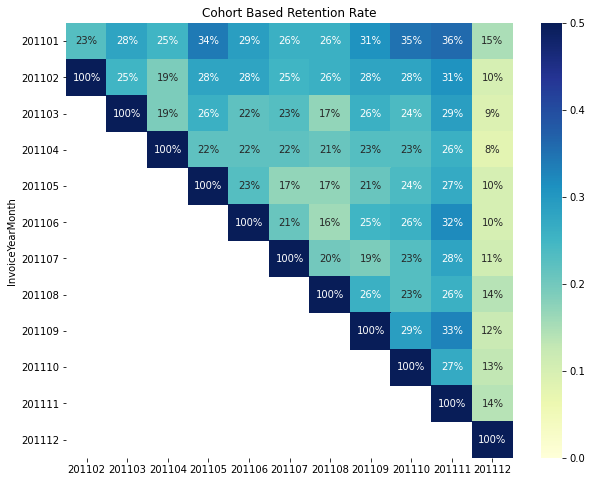

time: 721 ms (started: 2021-07-28 18:06:47 +00:00)


In [43]:
plt.figure(figsize=(10,8))
plt.title("Cohort Based Retention Rate")

ax = sns.heatmap(tx_retention[tx_retention.columns[2:]], 
                 cmap="YlGnBu", 
                 fmt='.0%',
                 vmin=0.0,
                 vmax=0.5,
                 annot=True)

Cohort based retention最重要的还是解释这个图：

![](https://img2018.cnblogs.com/blog/1247570/201908/1247570-20190828195600411-90387992.png)

We can see that first month retention rate became better recently (don’t take Dec ’11 into account) and in almost 1 year, 15% of our customers retain with us.

**First-month retention rate / churn rate = ~15%**

可以看出第一个月的用户的留存率非常高，四月和八月拉新的留存率不行，需要调查到底这俩月发生了什么情况

# Part 2: [Customer Segmentation (RFM)](https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444)

Segmentation by RFM clustering

In the previous article, we have analyzed the major metrics for our online retail business. Now we know what and how to track by using Python. It’s time to focus on customers and segment them.

Because you can’t treat every customer the same way with the same content, same channel, same importance. They will find another option which understands them better.

好了，知道了大概的metrics, 我们就需要对客户进行分组，知道哪些客户是最重要的，哪些客户是不能丢的，哪些是需要积极争取的。

**RFM还有很重要的一点就是为别的一些prediction和analysis提供依据。**

You can do many different segmentations according to what you are trying to achieve. If you want to increase retention rate, you can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now we are going to implement one of them to our business: **RFM**.

**RFM** stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:


### Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [44]:
#convert the string date field to datetime
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

#we will be using only UK data
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

time: 141 ms (started: 2021-07-28 18:06:48 +00:00)


In [45]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']

#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


time: 46.4 ms (started: 2021-07-28 18:06:48 +00:00)


In [46]:
tx_user[['Recency']].describe()

,Recency
count,3950.000000
mean,90.778481
std,100.230349
min,0.000000
25%,16.000000
50%,49.000000
75%,142.000000
max,373.000000


time: 19.7 ms (started: 2021-07-28 18:06:48 +00:00)


看一下recency的分布情况：

In [47]:
#plot a recency histogram

plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()
#pyoff.iplot(fig)

time: 187 ms (started: 2021-07-28 18:06:48 +00:00)


不用人工分箱，直接用K-Means clustering来分箱。下面还用到了order_clustering，让group name变得有区分active和inactive的意义：

Now it is the fun part. We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia. Code snippet and Inertia graph are as follows:

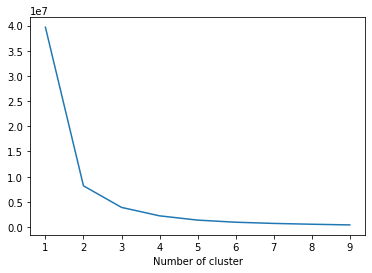

time: 1.65 s (started: 2021-07-28 18:06:49 +00:00)


In [48]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 for this example:

In [49]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

time: 91.2 ms (started: 2021-07-28 18:06:50 +00:00)


In [50]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
2,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


time: 36.4 ms (started: 2021-07-28 18:06:50 +00:00)


In [51]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

time: 24.3 ms (started: 2021-07-28 18:06:50 +00:00)


In [52]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


time: 40.5 ms (started: 2021-07-28 18:06:50 +00:00)


We have added one function to our code which is order_cluster(). K-means assigns clusters as numbers but not in an ordered way. We can’t say cluster 0 is the worst and cluster 4 is the best. order_cluster() method does this for us and our new dataframe looks much neater:

Great! group 3 covers most recent customers whereas group 0 has the most inactive ones.

Let’s apply same for Frequency and Revenue.

### Frequency

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database:


In [53]:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


time: 39.1 ms (started: 2021-07-28 18:06:50 +00:00)


In [54]:
#plot the histogram
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

time: 185 ms (started: 2021-07-28 18:06:51 +00:00)


In [55]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


time: 140 ms (started: 2021-07-28 18:06:51 +00:00)


As the same notation as recency clusters, high frequency number indicates better customers.

### Revenue

Let’s see how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [56]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

#plot the histogram
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 214 ms (started: 2021-07-28 18:06:51 +00:00)


We have some customers with negative revenue as well. Let’s continue and apply k-means clustering:


In [57]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


time: 128 ms (started: 2021-07-28 18:06:51 +00:00)


Overall Score

Awesome! We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them:

In [58]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


time: 22.1 ms (started: 2021-07-28 18:06:51 +00:00)


The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.

To keep things simple, better we name these scores:

- 0 to 2: Low Value
- 3 to 4: Mid Value
- 5+: High Value

In [59]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0     474
1     562
2     920
3    1511
4     298
5     148
6      27
7       7
8       3
Name: Recency, dtype: int64

time: 8.03 ms (started: 2021-07-28 18:06:51 +00:00)


In [60]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

time: 7.61 ms (started: 2021-07-28 18:06:51 +00:00)


Now, it is the best part. Let’s see how our segments distributed on a scatter plot:

In [61]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 255 ms (started: 2021-07-28 18:06:51 +00:00)


In [62]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 260 ms (started: 2021-07-28 18:06:52 +00:00)


In [63]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 234 ms (started: 2021-07-28 18:06:52 +00:00)


We can start taking actions with this segmentation. The main strategies are quite clear:

- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency


*Ideally, what we do here can be easily achieved by using quantiles or simple binning (or Jenks natural breaks optimization to make groups more accurate) but we are using k-means to get familiar with it.


# Part 3: [Customer Life Time Value](https://towardsdatascience.com/data-driven-growth-with-python-part-3-customer-lifetime-value-prediction-6017802f2e0f)

Now it’s time to measure one of the most important metric we should closely track: Customer Lifetime Value.

We invest in customers (acquisition costs, offline ads, promotions, discounts & etc.) to generate revenue and be profitable. Naturally, these actions make some customers super valuable in terms of lifetime value but there are always some customers who pull down the profitability. We need to identify these behavior patterns, segment customers and act accordingly.

我们的客户可不是从天上飘来的，而是我们各个渠道花费了很大代价的，知道每个用户Life Time Value是非常重要的！

Calculating Lifetime Value is the easy part. First we need to select a time window. It can be anything like 3, 6, 12, 24 months. By the equation below, we can have Lifetime Value for each customer in that specific time window:

> Lifetime Value: Total Gross Revenue - Total Cost

Let’s identify our path to glory:
- Define an appropriate time frame for Customer Lifetime Value calculation
- Identify the features we are going to use to predict future and create them
- Calculate lifetime value (LTV) for training the machine learning model
- Build and run the machine learning model
- Check if the model is useful

Deciding the time frame really depends on your industry, business model, strategy and more. For some industries, 1 year is a very long period while for the others it is very short. In our example, **we will go ahead with 6 months**.

也就是观察每个顾客在6个月的time window里面，LTV是多少


In [64]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans


#import plotly.plotly as py
#import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

time: 122 ms (started: 2021-07-28 18:06:52 +00:00)


In [65]:
#initate plotly
#pyoff.init_notebook_mode()

#read data from csv and redo the data work we done before
#tx_data = pd.read_csv('data.csv')
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

time: 119 ms (started: 2021-07-28 18:06:52 +00:00)


In [66]:
#converting the type of Invoice Date Field from string to datetime.
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

#creating YearMonth field for the ease of reporting and visualization
tx_data['InvoiceYearMonth'] = tx_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
tx_data['Revenue'] = tx_data['UnitPrice'] * tx_data['Quantity']

tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


time: 2.94 s (started: 2021-07-28 18:06:52 +00:00)


In [67]:
#create 3m and 6m dataframes
tx_3m = tx_uk[(tx_uk.InvoiceDate.dt.date  < date(2011,6,1)) & (tx_uk.InvoiceDate.dt.date >= date(2011,3,1))].reset_index(drop=True)
tx_6m = tx_uk[(tx_uk.InvoiceDate.dt.date  >= date(2011,6,1)) & (tx_uk.InvoiceDate.dt.date < date(2011,12,1))].reset_index(drop=True)

#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


time: 786 ms (started: 2021-07-28 18:06:55 +00:00)


In [68]:
#calculate recency score
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#calcuate frequency score
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#calcuate revenue score
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)


#overall scoring
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

time: 219 ms (started: 2021-07-28 18:06:56 +00:00)


In [69]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


time: 24.1 ms (started: 2021-07-28 18:06:56 +00:00)


let’s calculate 6 months LTV for each customer which we are going to use for training our model.

There is no cost specified in the dataset. That’s why Revenue becomes our LTV directly.

由于没有cost，这里直接用revenue当做LTV

In [70]:
#calculate revenue and create a new dataframe for it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

tx_user_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


time: 34.2 ms (started: 2021-07-28 18:06:56 +00:00)


In [71]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6 month Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 197 ms (started: 2021-07-28 18:06:56 +00:00)


In [72]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')
tx_merge = tx_merge.fillna(0)

tx_graph = tx_merge.query("m6_Revenue < 30000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 232 ms (started: 2021-07-28 18:06:57 +00:00)


Positive correlation is quite visible here. High RFM score means high LTV.

Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):

- Low LTV
- Mid LTV
- High LTV

We are going to apply K-means clustering to decide segments and observe their characteristics:

In [73]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


time: 110 ms (started: 2021-07-28 18:06:57 +00:00)


2 is the best with average 8.2k LTV whereas 0 is the worst with 396.

There are few more step before training the machine learning model:
- Need to do some feature engineering. We should convert categorical columns to numerical columns.
- We will check the correlation of features against our label, LTV clusters.
- We will split our feature set and label (LTV) as X and y. We use X to predict y.
- Will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our model to Test set to see its real performance.

In [74]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.845933
Revenue               0.600491
RevenueCluster        0.463930
OverallScore          0.373231
FrequencyCluster      0.366366
Frequency             0.359601
Segment_High-Value    0.353218
RecencyCluster        0.236899
Segment_Mid-Value     0.166854
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.266008
Name: LTVCluster, dtype: float64

time: 18.5 ms (started: 2021-07-28 18:06:57 +00:00)


We see that 3 months Revenue, Frequency and RFM scores will be helpful for our machine learning models.

In [75]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)


time: 12.9 ms (started: 2021-07-28 18:06:57 +00:00)


In [76]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.86
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        70
           1       0.75      0.50      0.60        18
           2       0.50      0.50      0.50         4

    accuracy                           0.86        92
   macro avg       0.71      0.66      0.68        92
weighted avg       0.85      0.86      0.85        92

time: 541 ms (started: 2021-07-28 18:06:57 +00:00)


Precision and recall are acceptable for 0. As an example, for cluster 0 (Low LTV), if model tells us this customer belongs to cluster 0, 90 out of 100 will be correct (precision). And the model successfully identifies 93% of actual cluster 0 customers (recall). We really need to improve the model for other clusters. For example, we barely detect 56% of Mid LTV customers. Possible actions to improve those points:
- Adding more features and improve feature engineering
- Try different models other than XGBoost
- Apply hyper parameter tuning to current model
- Add more data to the model if possible

Great! Now we have a machine learning model which predicts the future LTV segments of our customers. We can easily adapt our actions based on that. For example, we definitely do not want to lose customers with high LTV.

# Part 4: [Churn Prediction Model](https://towardsdatascience.com/churn-prediction-3a4a36c2129a)

Since we know our best customers by segmentation and lifetime value prediction, we should also work hard on retaining them. That’s what makes Retention Rate is one of the most critical metrics.

Retention Rate is an indication of how good is your product market fit (PMF, which is the degree to which a product satisfies a strong market demand). If your PMF is not satisfactory, you should see your customers churning very soon. **One of the powerful tools to improve Retention Rate (hence the PMF) is Churn Prediction**. By using this technique, you can easily find out who is likely to churn in the given period. In this article, we will use a Telco dataset and go over the following steps to develop a Churn Prediction model:
- Exploratory data analysis
- Feature engineering
- Investigating how the features affect Retention by using Logistic - Regression
- Building a classification model with XGBoost

我们得到的数据集是已经label好了churn还是不churn，依据的就是已经3个月，6个月不再购买，当然这个是看具体的业务，iphone手机也不能每个月换一次，你也不能说他churn了。。还可以做很多特征组合，分behavior，journey，等创作出很多新的feature。

得到了churn之后，现实中可以用下列依据制定策略：
1. 数据RFM中间group，太低的group反正价值也不大
2. 每一组中Recency特别低的用户
3. 还需要和LTV比较

## Exploratory Data Analysis

We start with checking out how our data looks like and visualize how it interacts with our label (churned or not?). Let’s start with importing our data and print the first ten rows:

In [77]:
df_data = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


time: 214 ms (started: 2021-07-28 18:06:58 +00:00)


In [78]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


It seems like our data fall under two categories:
- Categorical features: gender, streaming tv, payment method &, etc.
- Numerical features: tenure, monthly charges, total charges

Now starting from the categorical ones, we shed light on all features and see how helpful they are to identify if a customer is going to churn.

As a side note, in the dataset we have, Churn column is string with Yes/No values. We convert it to integer to make it easier to use in our analysis.

In [79]:
df_data.loc[df_data.Churn=='No','Churn'] = 0 
df_data.loc[df_data.Churn=='Yes','Churn'] = 1

time: 7.26 ms (started: 2021-07-28 18:06:58 +00:00)


接下来一个个value掰开了揉碎了看churn rate

1. Gender

By using the code block below, we easily visualize how Churn Rate (1-Retention Rate) looks like for each value:

In [80]:
df_plot = df_data.groupby('gender').Churn.apply(np.mean).reset_index()

df_plot

,gender,Churn
0,Female,0.269209
1,Male,0.261603


time: 18.4 ms (started: 2021-07-28 18:06:58 +00:00)


In [81]:
plot_data = [
    go.Bar(
        x=df_plot['gender'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Gender',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 173 ms (started: 2021-07-28 18:06:58 +00:00)


Female customers are more likely to churn vs. male customers, but the difference is minimal (~0.8%).

**Let’s replicate this for all categorical columns. To not repeat what we did for gender, you can find the code needed for all below:**

Now we go over the features which show the most significant difference across their values:

Internet Service

In [82]:
df_plot = df_data.groupby('Partner').Churn.apply(np.mean).reset_index()
plot_data = [
    go.Bar(
        x=df_plot['Partner'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Partner',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 184 ms (started: 2021-07-28 18:06:58 +00:00)


In [83]:
df_plot = df_data.groupby('InternetService').Churn.apply(np.mean).reset_index()
plot_data = [
    go.Bar(
        x=df_plot['InternetService'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Partner',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 187 ms (started: 2021-07-28 18:06:58 +00:00)


This chart reveals customers who have Fiber optic as Internet Service are more likely to churn. I normally expect Fiber optic customers to churn less due to they use a more premium service. But this can happen due to high prices, competition, customer service, and many other reasons.


In [84]:
df_plot = df_data.groupby('tenure').Churn.apply(np.mean).reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['tenure'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Tenure"},
        title='Tenure based Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 190 ms (started: 2021-07-28 18:06:58 +00:00)


Super apparent that the higher tenure means lower Churn Rate. We are going to apply the same for Monthly and Total Charges:

## Feature Engineering

In this section, we are going to transform our raw features to extract more information from them. Our strategy is as follows:

1. Group the numerical columns by using clustering techniques
2. Apply `Label Encoder` to categorical features which are binary
3. Apply `get_dummies()` to categorical features which have multiple values




### Numerical Columns

As we know from the EDA section, We have three numerical columns:
- Tenure
- Monthly Charges
- Total Charges

We are going to apply the following steps to create groups:
 
1. Using Elbow Method to identify the appropriate number of clusters
2. Applying K-means logic to the selected column and change the naming
3. Observe the profile of clusters

Let’s check how this works for Tenure in practice:

Cluster profiles:

In [85]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

time: 8.98 ms (started: 2021-07-28 18:06:59 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

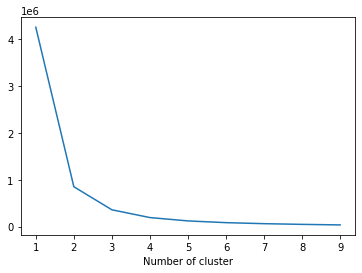

time: 1.23 s (started: 2021-07-28 18:06:59 +00:00)


In [86]:
sse={}
df_cluster = df_data[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [87]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

time: 75.9 ms (started: 2021-07-28 18:07:00 +00:00)


In [88]:
df_data = order_cluster('TenureCluster', 'tenure',df_data,True)

time: 30.1 ms (started: 2021-07-28 18:07:00 +00:00)


In [89]:
df_data.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2878.0,7.512509,5.977337,0.0,2.0,6.0,12.0,20.0
1,1926.0,33.854102,8.208706,21.0,26.0,34.0,41.0,48.0
2,2239.0,63.048682,7.478229,49.0,56.0,64.0,70.0,72.0


time: 30 ms (started: 2021-07-28 18:07:00 +00:00)


We have 3 clusters with 7.5, 33.9 and 63 as their average Tenure.

In [90]:
df_data['TenureCluster'] = df_data["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

time: 4.68 ms (started: 2021-07-28 18:07:00 +00:00)


In [91]:
df_plot = df_data.groupby('TenureCluster').Churn.apply(np.mean).reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TenureCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5,0.5],
        marker=dict(
        color=['green', 'blue', 'orange','red'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Tenure Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 184 ms (started: 2021-07-28 18:07:00 +00:00)


In [92]:

df_plot = df_data.copy()
df_plot['MonthlyCharges'] = df_plot['MonthlyCharges'].astype(int)
df_plot = df_plot.groupby('MonthlyCharges').Churn.apply(np.mean).reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['MonthlyCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Monthly Charges"},
        title='Monthly Charge vs Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 226 ms (started: 2021-07-28 18:07:00 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

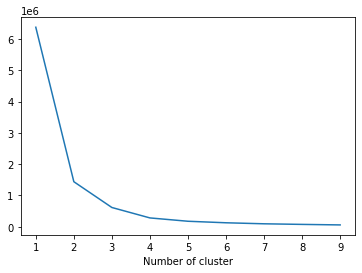

time: 1.54 s (started: 2021-07-28 18:07:01 +00:00)


In [93]:
sse={}
df_cluster = df_data[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [94]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargeCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

time: 74.2 ms (started: 2021-07-28 18:07:02 +00:00)


In [95]:
df_data = order_cluster('MonthlyChargeCluster', 'MonthlyCharges',df_data,True)

time: 34.1 ms (started: 2021-07-28 18:07:02 +00:00)


In [96]:
df_data.groupby('MonthlyChargeCluster').MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargeCluster,,,,,,,,
0,1892.0,23.384619,5.660437,18.25,19.80,20.40,25.0500,42.40
1,2239.0,61.628808,10.441432,42.60,51.80,61.55,70.7000,77.80
2,2912.0,94.054258,10.343944,77.85,85.05,93.90,101.9125,118.75


time: 39 ms (started: 2021-07-28 18:07:02 +00:00)


In [97]:
df_data['MonthlyChargeCluster'] = df_data["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

time: 5.77 ms (started: 2021-07-28 18:07:02 +00:00)


In [98]:
df_plot = df_data.groupby('MonthlyChargeCluster').Churn.apply(np.mean).reset_index()
plot_data = [
    go.Bar(
        x=df_plot['MonthlyChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Monthly Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 207 ms (started: 2021-07-28 18:07:02 +00:00)


In [99]:
df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureCluster,MonthlyChargeCluster
91,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0,Low,Low
136,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0,Low,Low
416,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0,Low,Low
478,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0,Low,Low
556,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0,Low,Low


time: 59.6 ms (started: 2021-07-28 18:07:03 +00:00)


In [100]:
len(df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()])

11

time: 14.9 ms (started: 2021-07-28 18:07:03 +00:00)


In [101]:
df_data.loc[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan

time: 9.33 ms (started: 2021-07-28 18:07:03 +00:00)


In [102]:
df_data = df_data.dropna()

time: 21.2 ms (started: 2021-07-28 18:07:03 +00:00)


In [103]:
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'], errors='coerce')

time: 10.1 ms (started: 2021-07-28 18:07:03 +00:00)


In [104]:
df_plot = df_data.copy()
df_plot['TotalCharges'] = df_plot['TotalCharges'].astype(int)
df_plot = df_plot.groupby('TotalCharges').Churn.apply(np.mean).reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['TotalCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Total Charges"},
        title='Total Charge vs Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 948 ms (started: 2021-07-28 18:07:03 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

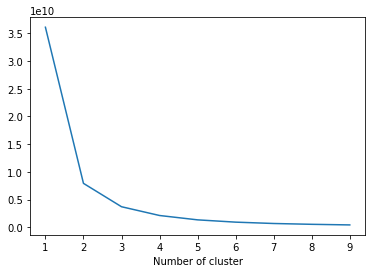

time: 2 s (started: 2021-07-28 18:07:04 +00:00)


In [105]:

sse={}
df_cluster = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [106]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargeCluster'] = kmeans.predict(df_data[['TotalCharges']])


time: 73.3 ms (started: 2021-07-28 18:07:06 +00:00)


In [107]:
df_data = order_cluster('TotalChargeCluster', 'TotalCharges',df_data,True)

time: 34.5 ms (started: 2021-07-28 18:07:06 +00:00)


In [108]:
df_data.groupby('TotalChargeCluster').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargeCluster,,,,,,,,
0,4166.0,688.070319,573.722183,18.80,161.725,537.775,1145.1625,1985.15
1,1611.0,3281.164184,814.282942,1988.05,2553.850,3219.750,3975.2000,4786.15
2,1255.0,6297.778685,1001.345310,4793.80,5478.075,6151.900,7044.1750,8684.80


time: 35.3 ms (started: 2021-07-28 18:07:06 +00:00)


In [109]:
df_data['TotalChargeCluster'] = df_data["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

time: 4.75 ms (started: 2021-07-28 18:07:06 +00:00)


In [110]:
df_plot = df_data.groupby('TotalChargeCluster').Churn.apply(np.mean).reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TotalChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Total Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

time: 184 ms (started: 2021-07-28 18:07:06 +00:00)


### Categorical Columns

`Label Encoder` converts categorical columns to numerical by simply assigning integers to distinct values. For instance, the column `gender` has two values: Female & Male. Label encoder will convert it to 1 and 0.

`get_dummies()` method creates new columns out of categorical ones by assigning 0 & 1s (you can find the exact explanation in our previous article)

Let’s see both in practice:

In [111]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns)

time: 59.9 ms (started: 2021-07-28 18:07:06 +00:00)


In [112]:
df_data[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid
0,0,1,0,1,0
1,0,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,1,0,1,0


time: 22.2 ms (started: 2021-07-28 18:07:06 +00:00)


As you can see easily, gender & Partner columns became numerical ones, and we have three new columns for TenureCluster.

It is time to fit a logistic regression model and extract insights to make better business decisions.

## Logistic Regression
Predicting churn is a binary classification problem. Customers either churn or retain in a given period. Along with being a robust model, Logistic Regression provides interpretable outcomes too. As we did before, let’s sort out our steps to follow for building a Logistic Regression model:

1. Prepare the data (inputs for the model)
2. Fit the model and see the model summary

And the summary looks like below:

In [113]:
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df_data.columns = all_columns

time: 4.45 ms (started: 2021-07-28 18:07:06 +00:00)


In [114]:
glm_columns = 'gender'

for column in df_data.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

time: 3.24 ms (started: 2021-07-28 18:07:06 +00:00)


In [115]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2900.0
Date:                Wed, 28 Jul 2021   Deviance:                       5799.9
Time:                        18:07:09   Pearson chi2:                 7.58e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

We have two important outcomes from this report. When you prepare a Churn Prediction model, you will face with the questions below:
1. Which characteristics make customers churn or retain?
2. What are the most critical ones? What should we focus on?

For the first question, you should look at the 4th column (P>|z|). If the absolute p-value is smaller than 0.05, it means, that feature affects Churn in a statistically significant way. Examples are:
- SeniorCitizen
- InternetService_DSL
- OnlineSecurity_NO


### ROI

这些coefficient可以告诉我们哪些feature能够最大影响churn rate，可以作为我们营销的起点。。

Then the second question. We want to reduce the Churn Rate, where we should start? The scientific version of this question is:

> Which feature will bring the best ROI if I increase/decrease it by one unit?

That question can be answered by looking at the **coef** column. **Exponential coef gives us the expected change in Churn Rate if we change it by one unit**. If we apply the code below, we will see the transformed version of all coefficients:

In [116]:
np.exp(res.params)

Intercept                                  1.276833
gender                                     0.974830
SeniorCitizen                              1.251653
Partner                                    1.003170
Dependents                                 0.874356
tenure                                     0.939094
PhoneService                               1.248565
PaperlessBilling                           1.415271
MonthlyCharges                             0.967164
TotalCharges                               1.000121
MultipleLines_No                           0.889492
MultipleLines_No_phone_service             1.022640
MultipleLines_Yes                          1.403683
InternetService_DSL                        0.550839
InternetService_Fiber_optic                2.818902
InternetService_No                         0.822298
OnlineSecurity_No                          1.381856
OnlineSecurity_No_internet_service         0.822298
OnlineSecurity_Yes                         1.123677
OnlineBackup

time: 14.5 ms (started: 2021-07-28 18:07:09 +00:00)


As an example, one unit change in Monthly Charge means ~3.4% improvement in the odds for churning if we keep everything else constant. From the table above, we can quickly identify which features are more important.

Now, everything is ready for building our classification model.

In [117]:
#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn

time: 11.8 ms (started: 2021-07-28 18:07:09 +00:00)


In [118]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

time: 8.69 ms (started: 2021-07-28 18:07:09 +00:00)


In [119]:
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.82
time: 1.19 s (started: 2021-07-28 18:07:09 +00:00)


Our actual Churn Rate in the dataset was 26.5% (reflects as 73.5% for model performance). This shows our model is a useful one. Better to check our classification model to see where exactly our model fails.

In [120]:
y_pred = xgb_model.predict(X_test)

time: 12.7 ms (started: 2021-07-28 18:07:10 +00:00)


In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       275
           1       0.59      0.55      0.57        77

    accuracy                           0.82       352
   macro avg       0.73      0.72      0.73       352
weighted avg       0.81      0.82      0.82       352

time: 10 ms (started: 2021-07-28 18:07:10 +00:00)


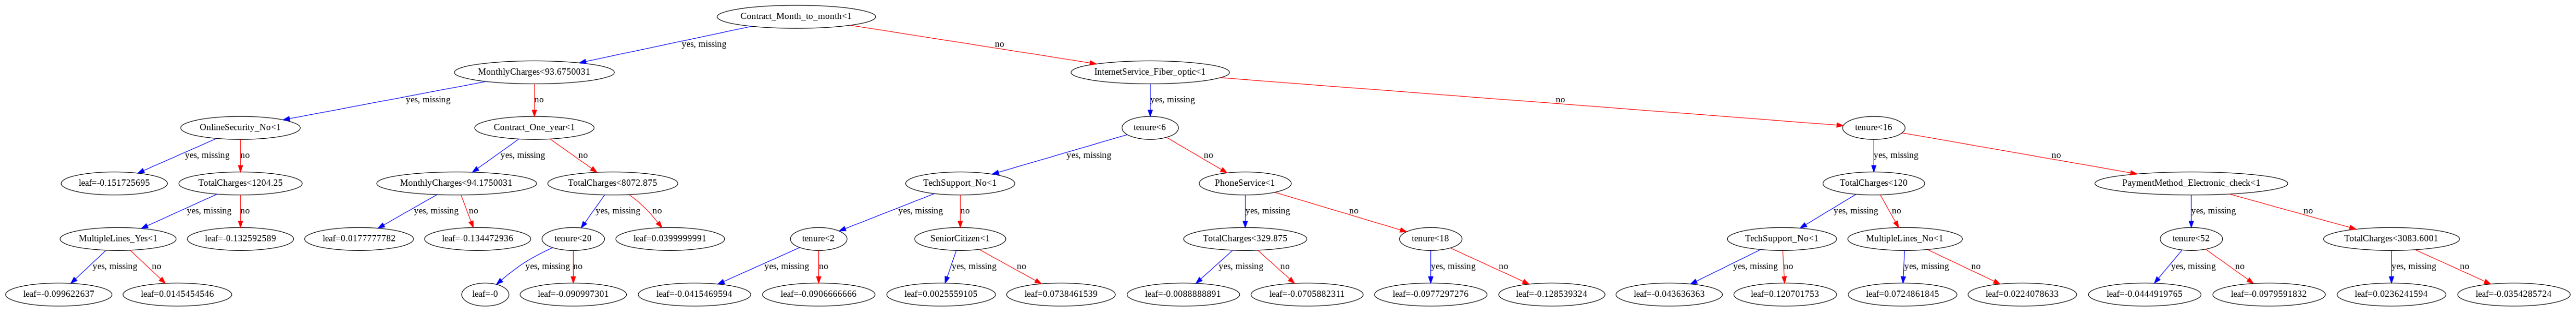

time: 3.15 s (started: 2021-07-28 18:07:10 +00:00)


In [122]:
from xgboost import plot_tree

##set up the parameters
fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax)


In [123]:
from xgboost import plot_importance

time: 1.42 ms (started: 2021-07-28 18:07:14 +00:00)


We can interpret the report above as if our model tells us, 100 customers will churn, 67 of it will churn (0.67 precision). And actually, there are around 220 customers who will churn (0.45 recall). Especially recall is the main problem here, and we can improve our model’s overall performance by:

- Adding more data (we have around 2k rows for this example)
- Adding more features
- More feature engineering
- Trying other models
- Hyper-parameter tuning

Moving forward, let’s see how our model works in detail. First off, we want to know which features our model exactly used from the dataset. Also, which were the most important ones?

For addressing this question, we can use the code below:

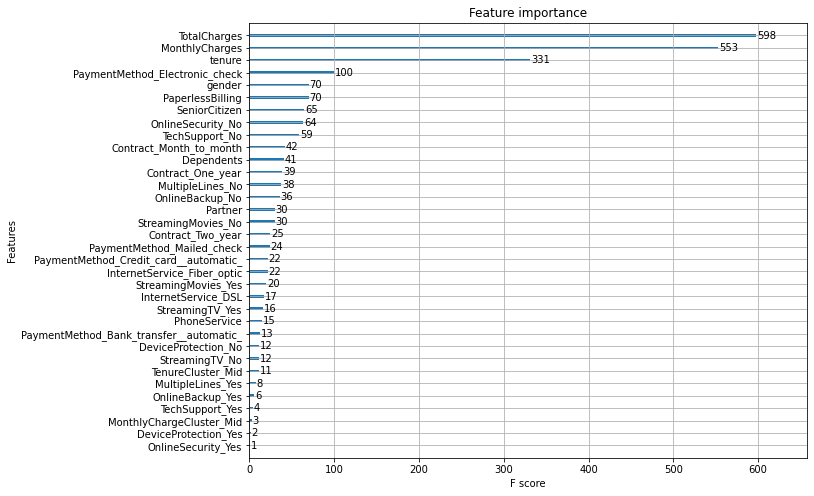

time: 778 ms (started: 2021-07-28 18:07:14 +00:00)


In [124]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

We can see that our model assigned more importance to **TotalCharges** and **MonthlyCharges** compared to others.

Finally, the best way to use this model is assigning Churn Probability for each customer, create segments, and build strategies on top of that. To get the churn probability from our model, utilize the code block below:

In [125]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

time: 44.5 ms (started: 2021-07-28 18:07:14 +00:00)


In [126]:
df_data[['customerID', 'proba']].head()

,customerID,proba
0,7590-VHVEG,0.592631
1,6713-OKOMC,0.146532
2,7469-LKBCI,0.013479
3,8779-QRDMV,0.919126
4,1680-VDCWW,0.042668


time: 22.8 ms (started: 2021-07-28 18:07:14 +00:00)


# Part 5: [Predicting Next Purchase Day](https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027?source=post_page---------------------------)

Predictive analytics helps us a lot on this one. One of the many opportunities it can provide is predicting the next purchase day of the customer. What if you know if a customer is likely to make another purchase in 7 days?

We can build our strategy on top of that and come up with lots of tactical actions like:

- No promotional offer to this customer since s/he will make a purchase anyways
- Nudge the customer with inbound marketing if there is no purchase in the predicted time window (or fire the guy who did the prediction 🦹‍♀️ 🦹‍♂️ )

这还是一个**分类问题**，因为我们预测的是时间窗口


In [19]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

#import plotly for visualization
# import plotly.plotly as py
# import plotly.offline as pyoff
import plotly.graph_objs as go

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [20]:
# df_purchase = pd.read_csv('purchase data.csv')

from google.colab import drive
drive.mount('/content/drive')

# Load the data, contained in the segmentation data csv file.
GD_PATH = '/content/drive/MyDrive/扬FAANG起航/单项准备/customer analytics/'
tx_data = pd.read_csv(GD_PATH+'OnlineRetail.csv', encoding = 'latin1', index_col = 0).reset_index()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Wrangling

Let’s start with importing our data and do the preliminary data work:

In [21]:
#convert date field from string to datetime
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

#create dataframe with uk data only
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

We have imported the CSV file, converted the date field from string to DateTime to make it workable and filtered out countries other than the UK.

To build our model, we should split our data into two parts:
![](https://miro.medium.com/max/1400/1*Gu6ofw3_G8Pvv2Cyal_F4Q.png)

**We use six months of behavioral data to predict customers’ first purchase date in the next three months.** 

If there is no purchase, we will predict that too. Let’s assume our cut off date is Sep 9th ’11 and split the data:

In [22]:
tx_6m = tx_uk[(tx_uk.InvoiceDate.dt.date < date(2011,9,1)) & (tx_uk.InvoiceDate.dt.date >= date(2011,3,1))].reset_index(drop=True)
tx_next = tx_uk[(tx_uk.InvoiceDate.dt.date >= date(2011,9,1)) & (tx_uk.InvoiceDate.dt.date < date(2011,12,1))].reset_index(drop=True)

tx_6m represents the six months performance whereas we will use tx_next for the find out the days between the last purchase date in tx_6m and the first one in tx_next.

Also, we will create a dataframe called tx_user to possess a user-level feature set for the prediction model:

In [23]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

将我们的数据分成了first six month - cut off - next three month, 然后label就是**cutoff 之前最后一次到cut off之后第一次purchase的时间差**。

By using the data in tx_next, we need the calculate our **label** (days between last purchase before cut off date and first purchase after that):

In [24]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')

#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

#print tx_user
tx_user.head()

#fill NA values with 999
tx_user = tx_user.fillna(999)

In [25]:
tx_user.head()

,CustomerID,NextPurchaseDay
0,14620.0,999.0
1,14740.0,999.0
2,13880.0,57.0
3,16462.0,111.0
4,17068.0,16.0


## Feature Engineering

For this project, we have selected our feature candidates like below:
- RFM scores & clusters
- Days between the last three purchases
- Mean & standard deviation of the difference between purchases in days

After adding these features, we need to deal with the categorical features by applying get_dummies method.

In [26]:
#get max purchase date for Recency and create a dataframe
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

tx_user.head()

#plot recency
# plot_data = [
#     go.Histogram(
#         x=tx_user['Recency']
#     )
# ]

# plot_layout = go.Layout(
#         title='Recency'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.show()

#clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#order recency clusters
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#print cluster characteristics
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,449.0,154.665924,15.863669,126.0,141.0,154.0,167.0,183.0
1,573.0,97.125654,13.976688,75.0,85.0,98.0,110.0,125.0
2,665.0,50.935338,12.413812,33.0,40.0,49.0,62.0,73.0
3,881.0,14.049943,8.883066,0.0,7.0,13.0,21.0,31.0


In [27]:
#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

#plot frequency
# plot_data = [
#     go.Histogram(
#         x=tx_user.query('Frequency < 1000')['Frequency']
#     )
# ]

# plot_layout = go.Layout(
#         title='Frequency'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.show()


#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2239.0,31.732023,26.036899,1.0,11.00,23.0,46.00,107.0
1,312.0,182.439103,70.488211,108.0,130.00,160.0,212.25,450.0
2,16.0,766.062500,260.797103,510.0,555.75,646.5,936.50,1251.0
3,1.0,3546.000000,NaN,3546.0,3546.00,3546.0,3546.00,3546.0


In [28]:
#calculate monetary value, create a dataframe with it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

#add Revenue column to tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

#plot Revenue
# plot_data = [
#     go.Histogram(
#         x=tx_user.query('Revenue < 10000')['Revenue']
#     )
# ]

# plot_layout = go.Layout(
#         title='Monetary Value'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

#Revenue clusters 
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

#ordering clusters and who the characteristics
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2415.0,635.360862,618.311128,-4287.63,212.1850,406.480,866.6600,2906.31
1,136.0,5237.716699,2617.500448,2952.40,3282.0950,4419.950,5634.9350,13760.87
2,15.0,24656.247333,7716.951663,15847.56,17484.2400,23196.350,31386.6450,37934.22
3,2.0,76665.615000,17370.382136,64382.90,70524.2575,76665.615,82806.9725,88948.33


In [29]:
#building overall segmentation
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

#assign segment names
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

Let’s focus on how we can add the next two features. We will be using shift() method a lot in this part.

First, we create a dataframe with Customer ID and Invoice Day (not datetime). Then we will remove the duplicates since customers can do multiple purchases in a day and difference will become 0 for those.

In [30]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate'].dt.date
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

Next, by using shift, we create new columns with the dates of last 3 purchases and see how our dataframe looks like:

In [31]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [32]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [47]:
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0


For each customer ID, we utilize .agg() method to find out the mean and standard deviation of the difference between purchases in days:

In [33]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

Now we are going to make a tough decision. The calculation above is quite useful for customers who have many purchases. But we can’t say the same for the ones with 1–2 purchases. For instance, it is too early to tag a customer as frequent who has only 2 purchases but back to back.
We only keep customers who have > 3 purchases by using the following line:

In [34]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [35]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

## Selecting a Machine Learning Model

Before jumping into choosing the model, we need to take two actions. First, we need to identify the classes in our label. Generally, percentiles give the right for that. Let’s use .describe() method to see them in **NextPurchaseDay**:


In [49]:
tx_user.NextPurchaseDay.describe()

count    623.000000
mean     176.390048
std      326.482713
min        0.000000
25%       24.500000
50%       47.000000
75%       87.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

Deciding the boundaries is a question for both statistics and business needs. It should make sense in terms of the first one and be easy to take action and communicate. Considering these two, we will have three classes:

- 0–20: Customers that will purchase in 0–20 days — **Class name: 2**
- 21–49: Customers that will purchase in 21–49 days — **Class name: 1**
- ≥ 50: Customers that will purchase in more than 50 days — **Class name: 0**

The last step is to see the correlation between our features and label. The correlation matrix is one of the cleanest ways to show this:

In [36]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

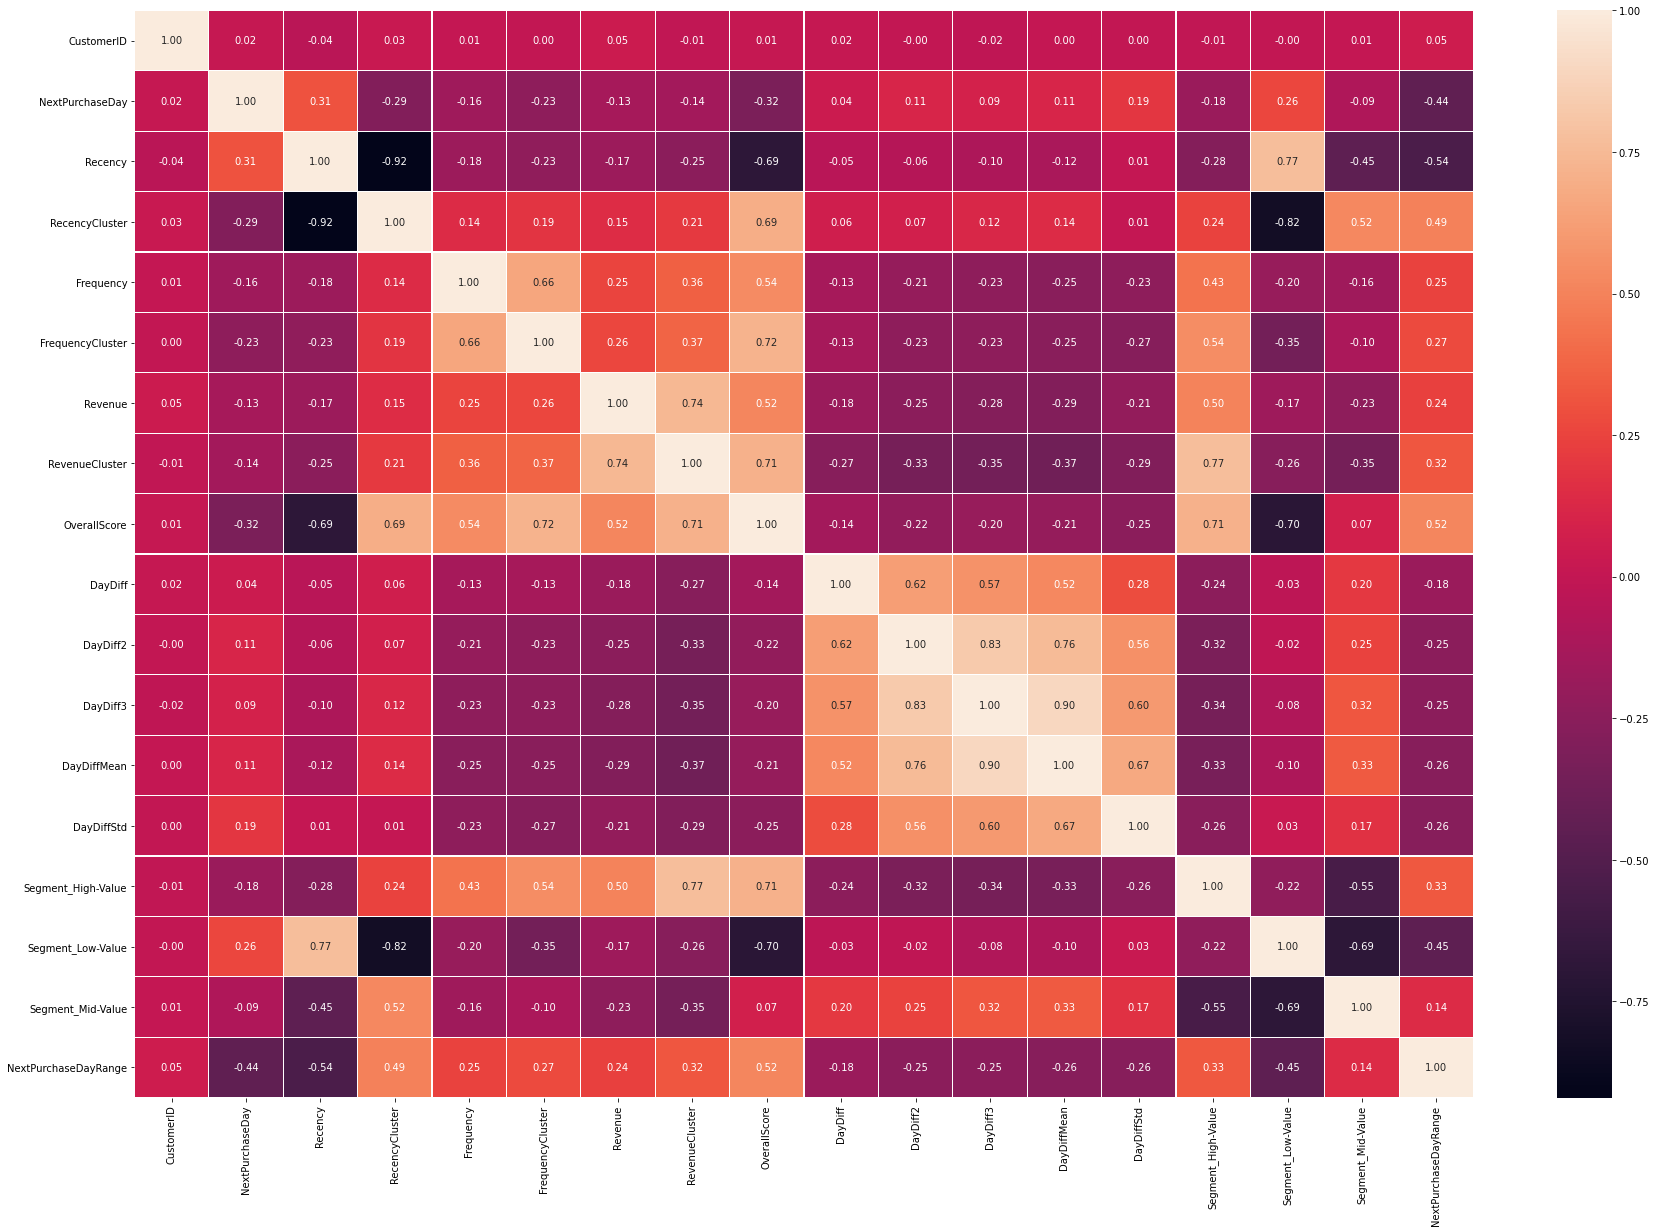

In [37]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

As expected  **Overall Score** has the highest positive correlation (0.45) and **Recency** has the highest negative (-0.54).

For this particular problem, we want to use the model which gives the highest accuracy. Let’s split train and test tests and measure the accuracy of different models:

In [38]:
#train & test split
tx_class = tx_class.drop('NextPurchaseDay',axis=1)
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.61445783 0.60240964]
NB [0.64257028 0.64658635]
RF [0.6064257  0.57429719]
SVC [0.50200803 0.4939759 ]
Dtree [0.5060241  0.53012048]
XGB [0.57429719 0.58232932]
KNN [0.4939759  0.48995984]


From this result, we see that Naive Bayes is the best performing one (~64% accuracy). But before that, let’s look at what we did exactly. We applied a fundamental concept in Machine Learning, which is Cross Validation.

## Multi-Classification Model

To build our model, we will follow the steps in the previous articles. But for improving it further, we’ll do Hyperparameter Tuning.
Programmatically, we will find out what are the best parameters for our model to make it provide the best accuracy.
Let’s start with coding our model first:



In [39]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.58


XGBClassifier has many parameters. You can find the list of them here. For this example, we will select max_depth and min_child_weight.
The code below will generate the best values for these parameters:


In [41]:
y_pred = xgb_model.predict(X_test)

In [42]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.73      0.68        55
           1       0.57      0.42      0.48        50
           2       0.48      0.60      0.53        20

    accuracy                           0.58       125
   macro avg       0.56      0.58      0.56       125
weighted avg       0.58      0.58      0.58       125



In [40]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.6044176706827309)

The algorithm says the best values are 3 and 5 for max_depth and min_child_weight respectively. Check out how it improves accuracy:

In [43]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=5).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.62


In [44]:
y_pred = xgb_model.predict(X_test)

In [45]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68        55
           1       0.64      0.54      0.59        50
           2       0.50      0.60      0.55        20

    accuracy                           0.62       125
   macro avg       0.60      0.62      0.61       125
weighted avg       0.63      0.62      0.62       125



# Part 6: [Predicting Sales (Time Series)](https://towardsdatascience.com/predicting-sales-611cb5a252de?source=post_page---------------------------)

Before this section, almost all our prediction models were on customer level (e.g. churn prediction, next purchase day, etc.). It is useful to zoom out and look at the broader picture as well. By considering all our efforts on the customer side, how do we affect the sales?

How does knowing the future sales helps our business?
1. First of all, it is a **benchmark**. We can use it as the business as usual level we are going to achieve if nothing changes in our strategy. Moreover, we can calculate the incremental value of our new actions on top of this benchmark.
2. Second, it can be utilized for **planning**. We can plan our demand and supply actions by looking at the forecasts. It helps to see where to invest more.
3. Last but not least, it is an excellent guide for **planning budgets and targets**.


## Data Wrangling

In [1]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

#import plotly for visualization
# import plotly.plotly as py
# import plotly.offline as pyoff
import plotly.graph_objs as go

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [3]:
# df_purchase = pd.read_csv('purchase data.csv')

from google.colab import drive
drive.mount('/content/drive')

# Load the data, contained in the segmentation data csv file.
GD_PATH = '/content/drive/MyDrive/扬FAANG起航/单项准备/customer analytics/'
df_sales = pd.read_csv(GD_PATH+'sales_data.csv', encoding = 'latin1', index_col = 0).reset_index()

Mounted at /content/drive


In [4]:
#convert date field from string to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'])

#show first 10 rows
df_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Our task is to forecast monthly total sales. We need to aggregate our data at the monthly level and sum up the sales column.

In [5]:
#represent month in date field as its first day
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
df_sales['date'] = pd.to_datetime(df_sales['date'])
#groupby date and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()

In [6]:
df_sales.head(5)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


## Data Transformation

To model our forecast easier and more accurate, we will do the transformations below:

- We will convert the data to stationary if it is not
- Converting from time series to supervised for having the feature set of our LSTM model
- Scale the data

First off, how do we check if the data is not stationary? Let’s plot it and see:

In [7]:
#plot monthly sales
plot_data = [
    go.Scatter(
        x=df_sales['date'],
        y=df_sales['sales'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

Obviously, it is not stationary and has an increasing trend over the months. One method is to get the difference in sales compared to the previous month and build the model on it:

In [8]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0
6,2013-07-01,855922,795597.0,60325.0
7,2013-08-01,766761,855922.0,-89161.0
8,2013-09-01,689907,766761.0,-76854.0
9,2013-10-01,656587,689907.0,-33320.0
10,2013-11-01,692643,656587.0,36056.0


In [9]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df_diff['date'],
        y=df_diff['diff'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show()

Perfect! Now we can start building our feature set. We need to use previous monthly sales data to forecast the next ones. The look-back period may vary for every model. Ours will be 12 for this example.
So what we need to do is to create columns from lag_1 to lag_12 and assign values by using shift() method:

In [10]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [11]:
df_supervised.head(10)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [12]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.02893426930900389


In [13]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.4497268445996091


if we add all 12 month's lag data, adj r^2 can achieve 95%+

In [14]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values


In [15]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

## Building the LSTM model

Everything is ready to build our first deep learning model. Let’s create feature and label sets from scaled datasets:

In [16]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [45]:
X_train.shape, y_train.shape

((41, 1, 12), (41, 1))

In [62]:
model = Sequential()
#model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful = True))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, verbose=1, shuffle=False)

Epoch 1/100
2/2 [==============================] - 3s 9ms/step - loss: 0.2363
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2341
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2320
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2299
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 0.2279
Epoch 6/100
2/2 [==============================] - 0s 10ms/step - loss: 0.2259
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2239
Epoch 8/100
2/2 [==============================] - 0s 11ms/step - loss: 0.2220
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2200
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2181
Epoch 11/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2162
Epoch 12/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2143
Epoch 13/100
2/2 [==============================] - 0s 8ms/

In [63]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

In [64]:
y_pred

array([[ 0.3080683 ],
       [-0.1804066 ],
       [-0.16708934],
       [-0.20255837],
       [-0.06627829],
       [-0.54741395]], dtype=float32)

In [65]:
y_test

array([[ 0.55964922],
       [-0.61313659],
       [-0.36228353],
       [-0.14316792],
       [ 0.23779333],
       [-1.02622661]])

## Convert back to actual sales prediction

Results look similar but it doesn’t tell us much because these are scaled data that shows the difference. How we can see the actual sales prediction?

1. 首先将pred_diff进行`inverse_transform`
2. 然后将pred_diff加到之前的act_sales, 也就是用之前的act_sales预测之后的sales


First, we need to do the inverse transformation for scaling:

In [66]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[ 0.30806831  0.26695937  0.44344626  0.60355899  1.10628178  0.13866328
  -0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168]]
[[-0.1804066   0.55964922  0.26695937  0.44344626  0.68877355  1.10628178
   0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352]]
[[-0.16708934 -0.61313659  0.55964922  0.26695937  0.52015228  0.68877355
   1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458]]
[[-0.20255837 -0.36228353 -0.61313659  0.55964922  0.33428672  0.52015228
   0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474]]
[[-0.06627829 -0.14316792 -0.36228353 -0.61313659  0.64253037  0.33428672
   0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439]]
[[-0.54741395  0.23779333 -0.14316792 -0.36228353 -0.59257833  0.64253037
   0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392]]


Second, we need to build the dataframe has the dates and the predictions. Transformed predictions are showing the difference. We should calculate the predicted sales numbers:

In [72]:
df_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [67]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].date)
act_sales = list(df_sales[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales

In [68]:
df_result

,pred_value,date
0,1117386,2017-07-01
1,1119296,2017-08-01
2,977164,2017-09-01
3,878410,2017-10-01
4,863562,2017-11-01
5,797955,2017-12-01


In [69]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['sales'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

Looks pretty good for a simple model.

One improvement we can do for this model is to add **holidays, breaks, and other seasonal effects**. They can be simply added as a new feature.

By using this model, we have our baseline sales predictions. But how we can predict the effect of a promotion on sales? We will look into it in Part 7.


# Part 7: [Uplift Modeling](https://towardsdatascience.com/market-response-models-baf9f9913298)

客户一般分这个么几种：
- 你不给coupon，他不convert
- 你给coupon他比较容易convert，
- 你再怎么给coupon，他就是不会convert
- 你给了coupon反而不容易convert了，就是矫情

![](https://pic1.zhimg.com/80/v2-5eca5d508effd41f7569f3923b74f2b4_1440w.jpg)

Uplift models预测增量值，也就是lift的部分：     
![](https://www.zhihu.com/equation?tex=%5Ctext+%7B+Lift+%7D%3DP%28%5Ctext+%7B+buy+%7D+%7C+%5Ctext+%7B+treatment+%7D%29-P%28%5Ctext+%7B+buy+%7D+%7C+%5Ctext+%7B+no+treatment+%7D%29)

理想中我们当然想找出persuadable的人群

- Treatment Responders: Customers that will purchase only if they receive an offer
- Treatment Non-Responders: Customer that won’t purchase in any case
- Control Responders: Customers that will purchase without an offer
- Control Non-Responders: Customers that will not purchase if they don’t receive an offer

The picture is very obvious. You need to target Treatment Responders (TR) and Control Non-Responders (CN). Since they won’t purchase unless you give an offer, these groups are boosting your uplift in promotional campaigns. On the other hand, you need to avoid targeting Treatment Non-Responders (TN) and Control Responders (CR). You will not benefit from targeting TN and, CN will make you cannibalize.

![](https://miro.medium.com/max/1400/1*AvNi0acKGyCs7jYsqcfl_w.png)

three are three types of uplift:
- Conversion Uplift: Conversion rate of test group - conversion rate of control group
- Order Uplift: Conversion uplift * # converted customer in test group
- Revenue Uplift: Order Uplift * Average order $ value




In [1]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

#import plotly for visualization
# import plotly.plotly as py
# import plotly.offline as pyoff
import plotly.graph_objs as go

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
#function for ordering cluster numbers for given criteria
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
    
 #import the data
df_data = pd.read_csv('https://gist.githubusercontent.com/karamanbk/ef1a118592e2f7954e5bb582e09bdde3/raw/03c6577e3ce2a9a4757b85be25618c919d618c32/data.csv')

#print first 10 rows
df_data.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


Our first 8 columns are providing individual-level data and conversion column is our label to predict:
- recency: months since last purchase
- history: $value of the historical purchases
- used_discount/used_bogo: indicates if the customer used a discount or buy one get one before
- zip_code: class of the zip code as Suburban/Urban/Rural
- is_referral: indicates if the customer was acquired from referral channel
- channel: channels that the customer using, Phone/Web/Multichannel
- offer: the offers sent to the customers, Discount/But One Get One/No Offer








In [3]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

  
#function for calculating the uplift
def calc_uplift(df):
    avg_order_value = 25
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
    
    if len(df[df.offer == 'Buy One Get One']['conversion']) > 0:
          
        print('-------------- \n')
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))     

In [4]:
calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


Discount looks like a better option if we want to get more conversion. It brings 7.6% uptick compared to the customers who didn’t receive any offer. BOGO (Buy One Get One) has 4.5% uptick as well.

总体来看discount的conversion uplift更高

## Multi-classification Model for Predicting the Uplift Score

Currently, our label is if a customer converted or not (1 or 0). We need to create four classes for TR, TN, CR, and CN. 

`Treatment` are customers who received discount and bogo offers are Treatment and the rest is `ContrOL`. Let’s create a `campaign_group` column make this info visible:

In [5]:
df_data['campaign_group'] = 'treatment'
df_data.loc[df_data.offer == 'No Offer', 'campaign_group'] = 'control'

In [7]:
df_data['target_class'] = 0 #CN
df_data.loc[(df_data.campaign_group == 'control') & (df_data.conversion > 0),'target_class'] = 1 #CR
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion == 0),'target_class'] = 2 #TN
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion > 0),'target_class'] = 3 #TR

In this example, the mapping of the classes are below:

- 0 -> Control Non-Responders
- 1 -> Control Responders
- 2 -> Treatment Non-Responders
- 3 -> Treatment Responders

There is one small feature engineering step before training our model. We will create clusters from history column and apply get_dummies for converting categorical columns into numerical:


In [8]:
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_data[['history']])
df_data['history_cluster'] = kmeans.predict(df_data[['history']])
#order the clusters
df_data = order_cluster('history_cluster', 'history',df_data,True)
#creating a new dataframe as model and dropping columns that defines the label
df_model = df_data.drop(['offer','campaign_group','conversion'],axis=1)
#convert categorical columns
df_model = pd.get_dummies(df_model)

Let’s fit our model and get the probabilities for each class:

In [9]:
#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

Variable class_probs possesses the probabilities for each customer. Let’s check out an example:

In [10]:
class_probs[0]

array([0.324392  , 0.01841972, 0.5913004 , 0.06588785], dtype=float32)

For this specific customer, we can map the probabilities as below:
- CN: 32%
- CR: 2%
- TN: 58.9%
- TR: 6.9%

So the uplift score for this customer is:

> 0.32 + 0.069- 0.02- 0.589 = -0.22

Let’s apply this to all users and calculate the uplift score:

In [11]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))
#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')
#assign it back to main dataframe
df_data['uplift_score'] = df_model['uplift_score']

By running the code above, we added a uplift_score column in our main dataframe and it looks like below:

In [12]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2,0,-0.223077
1,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2,0,-0.131298
2,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,treatment,3,0,-0.154009
3,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,treatment,2,0,-0.185353
4,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,treatment,2,0,-0.220525


## Model Evaluation

To evaluate our model, we will create two different groups and compare them with our benchmark. Groups are:

1. High Uplift Score: Customers have uplift score > 3rd quantile
2. Low Uplift Score: Customers have uplift score < 2nd quantile

We are going to compare:

- Conversion uplift
- Revenue uplift per target customer to see if our model can make our actions more efficient.

Here is our benchmark for the discount campaign.

In [14]:
df_data_lift = df_data.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)
#calculate the uplift
calc_uplift(df_data_lift)

Discount Conversion Uplift: 12.28%
Discount Order Uplift: 646.51
Discount Revenue Uplift: $16162.73



The results are great. Revenue uplift per target customer is 57% better and we can easily see that 25% of the target group is contributing to 40% of the revenue uplift.

We will check the same numbers for the group with the lower uplift score:

In [15]:
df_data_lift = df_data.copy()
uplift_q_5 = df_data_lift.uplift_score.quantile(0.5)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score < uplift_q_5)].reset_index(drop=True)
#calculate the uplift
calc_uplift(df_data_lift)

Discount Conversion Uplift: 5.63%
Discount Order Uplift: 604.06
Discount Revenue Uplift: $15101.47



As expected, revenue uplift per targeted customer decreased to $1.4. Moreover, the group is 50% of the targeted customers contributed to 37% of the revenue uplift.

By using this model, we can easily make our campaign more efficient by:
- Targeting specific segments based on the uplift score
- Trying different offers based on customer’s uplift score

# Part 8: MaRket Response Models

# Part 9: [A/B Testing Design & Execution](https://towardsdatascience.com/a-b-testing-design-execution-6cf9e27c6559)

As a (Data-Driven) Growth Hacker, one of the main responsibilities is to experiment new ideas and sustain continuous learning. Experimentation is a great way to test your machine learning models, new actions & improve existing ones. Let’s give an example:

You have a churn model that works with 95% accuracy. By calling the customers who are likely to churn and giving an attractive offer, you are assuming 10% of them will retain and bring monthly $20 per each.

That’s a lot of assumptions. Breaking it down:

- The model’s accuracy is 95%. Is it really? You have trained your model based on last month’s data. The next month, there will be new users, new product features, marketing & brand activities, seasonality and so on. Historical accuracy and real accuracy rarely match in this kind of cases. You can’t come up with a conclusion without a test.

- By looking at the previous campaigns’ results, you are assuming a 10% conversion. It doesn’t guarantee that your new action will have 10% conversion due to the factors above. Moreover, since it is a new group, their reaction is partly unpredictable.
- Finally, if those customers bring $20 monthly today, that doesn’t mean they will bring the same after your new action.

To see what’s going to happen, we need to conduct an A/B test. In this article, we are going to focus on how we can execute our test programmatically and report the statistics behind it. Just before jumping into coding, there are two important points you need to think while designing and A/B test.

1- What is your hypothesis?

Going forward with the example above, our hypothesis is, test group will have more retention:
>Group A → Offer → Higher Retention     
>Group B → No offer → Lower Retention

This also helps us to test model accuracy as well. If group B’s retention rate is 50%, it clearly shows that our model is not working. The same applies to measure revenue coming from those users too.

2- What is your success metric?

In this case, we are going to check the retention rate of both groups.


## Programmatic A/B Testing

For this coding example, we are going to create our own dataset by using numpy library and evaluate the result of an A/B test.
Let’s start with importing the necessary libraries:


In [17]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

# import plotly.plotly as py
# import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.figure_factory as ff

import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")

Now we are going to create our own dataset. The dataset will contain the columns below:
- **customer_id**: the unique identifier of the customer
- **segment**: customer’s segment; high-value or low-value
- **group**: indicates whether the customer is in the test or control group
- **purchase_count**: # of purchases completed by the customer

The first three will be quite easy:


In [18]:
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['group'] = 'control'
df_hv.loc[df_hv.index<10000,'group'] = 'test'

Ideally, purchase count should be a **Poisson distribution**. There will be customers with no purchase and we will have less customers with high purchase counts. Let’s use **numpy.random.poisson()** for doing that and assign different distributions to test and control group:

购买行为应该是**泊松分布**的，也就是一个月内购买的分布

In [19]:
df_hv.loc[df_hv.group == 'test', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'control', 'purchase_count'] = np.random.poisson(0.5, 10000)

In [20]:
df_hv.head()

,customer_id,segment,group,purchase_count
0,0,high-value,test,0.0
1,1,high-value,test,1.0
2,2,high-value,test,0.0
3,3,high-value,test,0.0
4,4,high-value,test,1.0


Awesome. We have everything to evaluate our A/B test. Assume we applied an offer to 50% of high-value users and observed their purchases in a given period. Best way to visualize it to check the densities:

In [24]:
test_results = df_hv[df_hv.group == 'test'].purchase_count
control_results = df_hv[df_hv.group == 'control'].purchase_count

hist_data = [test_results, control_results]

group_labels = ['test', 'control']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=.5,
                         curve_type='normal',show_rug=False)

fig.layout = go.Layout(
        title='High Value Customers Test vs Control',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )

fig.show()

In [25]:
from scipy import stats 
test_result = stats.ttest_ind(test_results, control_results)
print(test_result)

Ttest_indResult(statistic=11.863747040045416, pvalue=2.3448115656546288e-32)


In [26]:
def eval_test(test_results,control_results):
    test_result = stats.ttest_ind(test_results, control_results)
    if test_result[1] < 0.05:
        print('result is significant')
    else:
        print('result is not significant')

In [27]:
eval_test(test_results, control_results)

result is significant


Looks great but unfortunately, it is not that simple. If you select a biased test group, your results will be statistically significant by default. As an example, if we allocate more high-value customer to test group and more low-value customers to control group, then our experiment becomes a failure from the beginning. That’s why selecting the group is the key to a healthy A/B test.

## Selecting Test & Control Groups

The most common approach to select test & control groups is **random sampling**. Let’s see how we can do it programmatically. We are going to start with creating the dataset first. In this version, it will have 20k high-value and 80k low-value customers:

In [28]:
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['prev_purchase_count'] = np.random.poisson(0.9, 20000)
df_lv = pd.DataFrame()
df_lv['customer_id'] = np.array([count for count in range(20000,100000)])
df_lv['segment'] = np.array(['low-value' for _ in range(80000)])
df_lv['prev_purchase_count'] = np.random.poisson(0.3, 80000)
df_customers = pd.concat([df_hv,df_lv],axis=0)

In [29]:
df_test = df_customers.sample(frac=0.9)
df_control = df_customers[~df_customers.customer_id.isin(df_test.customer_id)]

In this example, we extracted 90% of the whole group and labeled it as test. But there is a small problem that can ruin our experiment. If you have significantly different multiple groups in your dataset (in this case, high-value & low-value), better to do random sampling separately. Otherwise, we can’t guarantee that the ratio of high-value to low-value is the same for test and control group.

To ensure creating test and control groups correctly, we need to apply the following code:

In [30]:
df_test_hv = df_customers[df_customers.segment == 'high-value'].sample(frac=0.9)
df_test_lv = df_customers[df_customers.segment == 'low-value'].sample(frac=0.9)
df_test = pd.concat([df_test_hv,df_test_lv],axis=0)
df_control = df_customers[~df_customers.customer_id.isin(df_test.customer_id)]

We have explored how to do the t-test and selecting test and control groups. But what if we are doing A/B/C test or A/B test on multiple groups like above. It’s time to introduce ANOVA tests.


## One-way ANOVA

Let’s assume we are testing 2+ variants on same groups (i.e 2 different offers and no-offer to low-value high-value customers). Then we need to apply one-way ANOVA for evaluating our experiment. Let’s start from creating our dataset:

In [31]:

#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(30000)])
df_hv['segment'] = np.array(['high-value' for _ in range(30000)])
df_hv['group'] = 'A'
df_hv.loc[df_hv.index>=10000,'group'] = 'B' 
df_hv.loc[df_hv.index>=20000,'group'] = 'C' 

df_hv.loc[df_hv.group == 'A', 'purchase_count'] = np.random.poisson(0.4, 10000)
df_hv.loc[df_hv.group == 'B', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'C', 'purchase_count'] = np.random.poisson(0.2, 10000)

a_stats = df_hv[df_hv.group=='A'].purchase_count
b_stats = df_hv[df_hv.group=='B'].purchase_count
c_stats = df_hv[df_hv.group=='C'].purchase_count

hist_data = [a_stats, b_stats, c_stats]

group_labels = ['A', 'B','C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=.5,
                         curve_type='normal',show_rug=False)

fig.layout = go.Layout(
        title='Test vs Control Stats',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )

fig.show()

In [32]:
def one_anova_test(a_stats,b_stats,c_stats):
    test_result = stats.f_oneway(a_stats, b_stats, c_stats)
    if test_result[1] < 0.05:
        print('result is significant')
    else:
        print('result is not significant')

In [33]:
one_anova_test(a_stats, b_stats, c_stats)

result is significant


In [34]:
df_hv.loc[df_hv.group == 'A', 'purchase_count'] = np.random.poisson(0.5, 10000)
df_hv.loc[df_hv.group == 'B', 'purchase_count'] = np.random.poisson(0.5, 10000)
df_hv.loc[df_hv.group == 'C', 'purchase_count'] = np.random.poisson(0.5, 10000)
a_stats = df_hv[df_hv.group=='A'].purchase_count
b_stats = df_hv[df_hv.group=='B'].purchase_count
c_stats = df_hv[df_hv.group=='C'].purchase_count
hist_data = [a_stats, b_stats, c_stats]
group_labels = ['A', 'B','C']
# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=.5,
                         curve_type='normal',show_rug=False)
fig.layout = go.Layout(
        title='Test vs Control Stats',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig.show()

## Two-way ANOVA

Let’s say we are doing the same test on both high-value and low-value customers. In this case, we need to apply two-way ANOVA. We are going to create our dataset again and build our evaluation method:

In [35]:
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['group'] = 'control'
df_hv.loc[df_hv.index<10000,'group'] = 'test' 
df_hv.loc[df_hv.group == 'control', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'test', 'purchase_count'] = np.random.poisson(0.8, 10000)


df_lv = pd.DataFrame()
df_lv['customer_id'] = np.array([count for count in range(20000,100000)])
df_lv['segment'] = np.array(['low-value' for _ in range(80000)])
df_lv['group'] = 'control'
df_lv.loc[df_lv.index<40000,'group'] = 'test' 
df_lv.loc[df_lv.group == 'control', 'purchase_count'] = np.random.poisson(0.2, 40000)
df_lv.loc[df_lv.group == 'test', 'purchase_count'] = np.random.poisson(0.3, 40000)

df_customers = pd.concat([df_hv,df_lv],axis=0)

In [36]:
import statsmodels.formula.api as smf 
from statsmodels.stats.anova import anova_lm
model = smf.ols(formula='purchase_count ~ segment + group ', data=df_customers).fit()
aov_table = anova_lm(model, typ=2)

In [38]:
print(np.round(aov_table, 4))

              sum_sq       df          F  PR(>F)
segment    3215.5662      1.0  9323.9814     0.0
group       348.8084      1.0  1011.4183     0.0
Residual  34486.0164  99997.0        NaN     NaN


This shows, segment (being high-value or low-value) significantly affects the purchase count but group doesn’t since it is almost 66%, way higher than 5%.

Now we know how to select our groups and evaluate the results. But there is one more missing part. To reach statistical significance, our sample size should be enough. Let’s see how we can calculate it.

## Sample Size Calculation

To calculate the required sample size, first we need to understand two concepts:

- Effect size: this represents the magnitude of difference between averages of test and control group. It is the variance in averages between test and control groups divided by the standard deviation of the control.

- Power: this refers to the probability of finding a statistical significance in your test. To calculate the sample size, 0.8 is the common value that is being used.

Let’s build our dataset and see the sample size calculation in an example:

In [39]:
from statsmodels.stats import power
ss_analysis = power.TTestIndPower()
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['prev_purchase_count'] = np.random.poisson(0.7, 20000)
purchase_mean = df_hv.prev_purchase_count.mean()
purchase_std = df_hv.prev_purchase_count.std()

In this example, the average of purchases (purchase_mean) is 0.7 and the standard deviation (purchase_std) is 0.84.

Let’s say we want to increase the purchase_mean to 0.75 in this experiment. We can calculate the effect size like below:

In [42]:
effect_size = (0.75 - purchase_mean) / purchase_std

In [43]:
alpha = 0.05
power = 0.8
ratio = 1
ss_result = ss_analysis.solve_power(effect_size=effect_size, power=power,alpha=alpha, ratio=ratio , nobs1=None) 
print(ss_result)

4653.732421078416


Alpha is the threshold for statistical significance (5%) and our ratio of test and control sample sizes are 1 (equal). As a result, our required sample size is (output of ss_result) 4868.

Let’s build a function to use this everywhere we want:

In [44]:
def calculate_sample_size(c_data, column_name, target,ratio):
    value_mean = c_data[column_name].mean()
    value_std = c_data[column_name].std()
    
    value_target = value_mean * target
    
    effect_size = (value_target - value_mean)/value_std
    
    power = 0.8
    alpha = 0.05
    ss_result = ss_analysis.solve_power(effect_size=effect_size, power=power,alpha=alpha, ratio=ratio , nobs1=None) 
    print(int(ss_result))

To this function, we need to provide our dataset, the column_name that represents the value (purchase_count in our case), our target mean (0.75 was our target in the previous example) and the ratio.

In the dataset above, let’s assume we want to increase purchase count mean by 5% and we will keep the sizes of both groups the same:

In [45]:
calculate_sample_size(df_hv, 'prev_purchase_count', 1.05,1)

9015
